# Develop `front_plots` Figure Module

Development of functions for `nowcast.figures.research.front_plots` web site figure module.

In [67]:
from types import SimpleNamespace

import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import nowcast
import nowcast.figures.website_theme
from salishsea_tools import viz_tools

from importlib import reload

In [68]:
%matplotlib inline

In [85]:
restart_names = {
    'sn' : { 
        'longname': 'Reference Salinity',
        'units': 'g/kg'},
    'TRNNO3' : {
        'longname': 'Nitrate',
        'units': 'mmol/m3'},
    'un' : {
        'longname': 'Speed',
        'units': 'm/s'},
    }

What make_plots provides:

## `_prep_plot_data()` Function

In [88]:
def _prep_plot_data(dataset, meshmask, variable, second):

    sj, ej = 300, 770
    si, ei = 100, 370
    
    values = dataset.variables[variable][0, 0, sj:ej, si:ei]
    
    e1t = meshmask.variables['e1t'][0, sj:ej, si:ei]
    e2t = meshmask.variables['e2t'][0, sj:ej, si:ei]
    
    if second == None: # tracer

        mvalues = np.ma.masked_where(
            meshmask["tmask"][0, 0, sj:ej, si:ei] == 0, values)
        
    else:  # velocity
    
        mfvalues = np.ma.masked_where(
            meshmask["umask"][0, 0, sj:ej, si:ei] == 0, values)
        svalues = dataset.variables[second][0, 0, sj:ej, si:ei]
        msvalues = np.ma.masked_where(
            meshmask["vmask"][0, 0, sj:ej, si:ei] == 0, svalues)
        uT = np.zeros_like(e1t)
        vT = np.zeros_like(e2t)
        uT[1:, 1:], vT[1:, 1:] = viz_tools.unstagger(mfvalues, msvalues)
        mvalues = np.sqrt(uT*uT+ vT*vT)
               
    vdx = (mvalues[1:, 1:] - mvalues[1:, 0:-1])/e1t[1:, 1:]   # associated with e1t
    vdy = (mvalues[1:, 1:] - mvalues[0:-1, 1:])/e2t[1:, 1:]   # associated with e2t
        
    grad = np.zeros_like(e1t)
    grad[1:, 1:] = np.sqrt(vdx*vdx + vdy*vdy)
    cbar_thres = 0.7 * np.max(grad)

    return SimpleNamespace(data=grad, 
                           surface_j_limits=(sj, ej),
                            surface_i_limits=(si, ei),
                           cbar_thres=cbar_thres, 
                          )

## `_prep_fig_axes() Function`

In [72]:
def _prep_fig_axes(figsize, theme):
    fig, ax = plt.subplots(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])

    ax.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    
    return fig, ax

## `_plot_fronts()` Function

In [73]:
def _plot_fronts(ax, plot_data, theme):
    x, y = np.meshgrid(
        np.arange(*plot_data.surface_i_limits, dtype=int),
        np.arange(*plot_data.surface_j_limits, dtype=int))
    mesh = ax.contourf(
        x, y, plot_data.data, cmap='inferno', vmax=plot_data.cbar_thres)
    
    cbar = plt.colorbar(mesh, ax=ax, fraction=0.034, pad=0.04, aspect=45)

    return cbar

## `_fronts_axes_labels()` Function

In [74]:
def _fronts_axes_labels(ax, variable, theme, cbar):


    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        'Gradient of ' + restart_names[variable]['longname'] + ' [' +
        restart_names[variable]['units'] + '/m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis'])
    ax.set_xlabel(
        'Grid x', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_ylabel(
        'Grid y', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_axis_bgcolor('burlywood')
    viz_tools.set_aspect(ax)
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [77]:
def make_figure(dataset,
                meshmask,
                variable,
                second,
                figsize=(20, 12),
                theme=nowcast.figures.website_theme):
    plot_data = _prep_plot_data(dataset, meshmask, variable, second)

    fig, ax = _prep_fig_axes(figsize, theme)
    cbar = _plot_fronts(ax, plot_data, theme)
    _fronts_axes_labels(ax, variable, theme, cbar)

    return fig

## Render the Figure


In [90]:
meshmask = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/mesh_mask201702.nc')

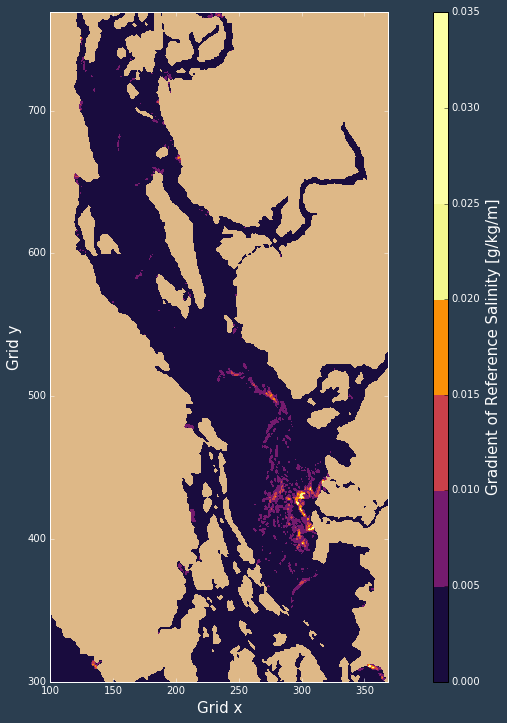

In [83]:
%%timeit -n1 -r1
datafile = '/results/SalishSea/hindcast/16may15/SalishSea_00533520_restart.nc'
dataset = nc.Dataset(datafile)
fig = make_figure(dataset, meshmask, 'sn', second=None)


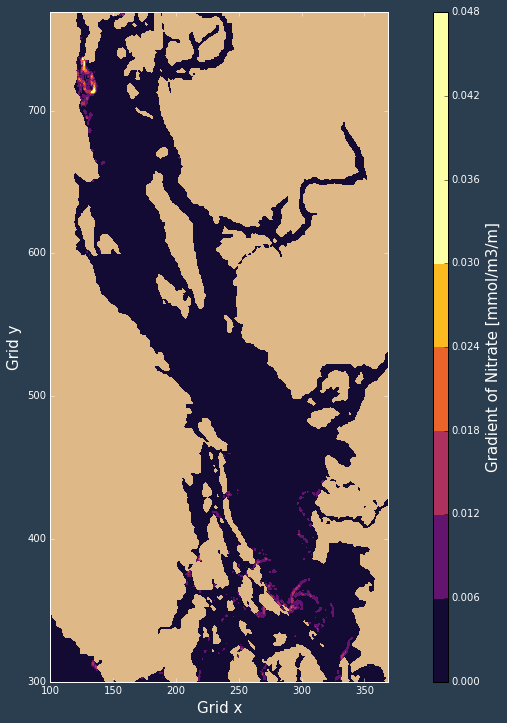

In [79]:
datafile = '/results/SalishSea/hindcast/16may15/SalishSea_00533520_restart_trc.nc'
dataset = nc.Dataset(datafile)
fig = make_figure(dataset, meshmask, 'TRNNO3', second=None)

/home/sallen/anaconda/envs/nowcast-fig-dev/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


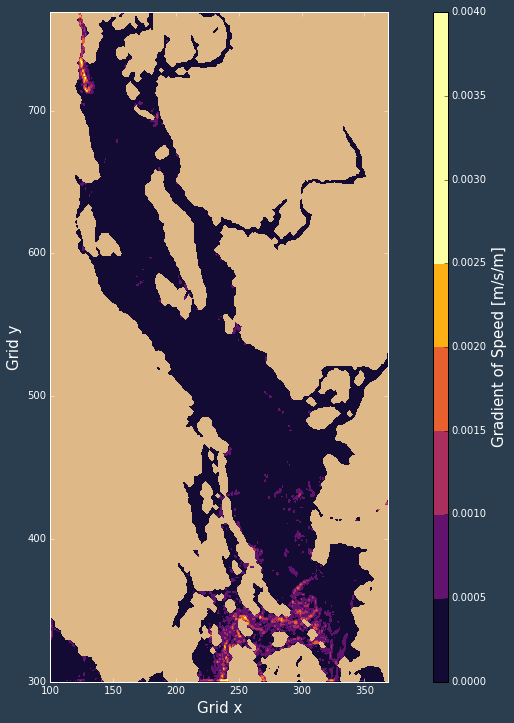

In [89]:
datafile = '/results/SalishSea/hindcast/16may15/SalishSea_00533520_restart.nc'
dataset = nc.Dataset(datafile)
fig = make_figure(dataset, meshmask, 'un', 'vn')